In [1]:
# %pip install numpy pandas matplotlib seaborn nltk
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as tkr
import seaborn as sns
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

import os
from graphs import *



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/oscarpinon/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# import prices

prices=pd.read_csv('datasets/values-of-top-nasdaq-copanies-from-2010-to-2020/CompanyValues.csv')
# format date
prices['day_date'] = pd.to_datetime(prices['day_date'], format="%Y-%m-%d").dt.date.astype('datetime64[ns]')
prices=prices.sort_values(by=['day_date']).reset_index()
# rename date column for consistency
prices=prices.rename(columns={"day_date": "date"})

def create_indicators(data):
    
    prices = data.sort_values(by=['date']).reset_index()

    # create simple moving average
    n=[10,20,50,100]
    for i in n:
        prices.loc[:,(str("MA"+str(i)))]=prices['close_value'].rolling(i).mean()    

    # Calculate MACD  
    day26=prices['close_value'].ewm(span=26, adjust=False).mean()
    day12=prices['close_value'].ewm(span=12, adjust=False).mean()
    prices.loc[:,('macd')]=day12-day26 
    prices.loc[:,('signal')]=prices['macd'].ewm(span=9, adjust=False).mean()

    # Calculate RSI 
    up = np.log(prices.close_value).diff(1)
    down = np.log(prices.close_value).diff(1)

    up[up<0]=0
    down[down>0]=0

    # Calculate the EWMA
    roll_up = up.ewm(span=14).mean()
    roll_down = down.abs().ewm(span=14).mean()

    # Calculate the RSI based on EWMA
    RS1 = roll_up / roll_down
    RSI1 = 100.0 - (100.0 / (1.0 + RS1))
    prices.loc[:,('rsi')]=RSI1

    return prices

# create dict, by ticker
d = dict(tuple(prices.groupby('ticker_symbol')))
d = {k:create_indicators(v) for k, v in d.items()}

def subset_prices(d,ticker,start,end):
    x=d[ticker]
    x=x[((x.date>=start)&(x.date<=end))]
    return x

In [3]:
# import tweets
tweets=pd.read_csv('datasets/tweets-about-the-top-companies-from-2015-to-2020/Tweet.csv')
company_tweet=pd.read_csv('datasets/tweets-about-the-top-companies-from-2015-to-2020/Company_Tweet.csv')

tweets=tweets.merge(company_tweet,how='left',on='tweet_id')
# format dates
tweets['date'] = pd.to_datetime(tweets['post_date'], unit='s').dt.date
tweets.date=pd.to_datetime( tweets.date,errors='coerce')
tweets['time'] = pd.to_datetime(tweets['post_date'], unit='s').dt.time

In [4]:
sia = SentimentIntensityAnalyzer()

def get_sentiment(tweets,ticker='TSLA',start='2017-01-01',end='2017-02-01'):
    #sbuset
    df=tweets.loc[((tweets.ticker_symbol==ticker)&(tweets.date>=start)&(tweets.date<=end))]

    df.loc[:,('score')]=df.loc[:,'body'].apply(lambda x: sia.polarity_scores(x)['compound'])
    # create label
    #bins= pd.interval_range(start=-1, freq=3, end=1)
    df.loc[:,('label')]=pd.cut(np.array(df.loc[:,'score']),bins=[-1, -0.33, 0.33, 1],right=True ,labels=["bad", "neutral", "good"])
    
    df=df.loc[:,["date","score","label","tweet_id","body"]]
    return df

text= 'tesla is Great, has to trend towards breakout , long buy'
print(text)
print(sia.polarity_scores(text))

get_sentiment(tweets)

tesla is Great, has to trend towards breakout , long buy
{'neg': 0.0, 'neu': 0.687, 'pos': 0.313, 'compound': 0.6249}


,date,score,label,tweet_id,body
1786176,2017-01-01,0.0000,neutral,815352552204238848,"$TSLA""I continue to believe that it’s the mark..."
1786180,2017-01-01,0.5984,good,815354565142937600,Baird analyst Ben Kallo is closing the year on...
1786181,2017-01-01,0.0000,neutral,815355389877354497,$TSLAKallo rates Tesla’ stock an ‘Outperform’ ...
1786187,2017-01-01,-0.5267,bad,815364373438930945,"With #Tesla and #SolarCity combined, fossil fu..."
1786194,2017-01-01,0.0000,neutral,815369598358781952,"$IBM Financials Updated Saturday, December 31,..."
...,...,...,...,...,...
1863946,2017-02-01,0.1779,neutral,826936895829585922,These assets are seeing a jump in tweets $CMG ...
1863955,2017-02-01,0.0000,neutral,826938171783053312,Here's a list of 14 stocks that are already up...
1863965,2017-02-01,0.0000,neutral,826940688138919938,Here's a list of 14 stocks that are already up...
1863968,2017-02-01,0.6597,good,826940848692621312,Commented on The Tesla Self-Driving Dreams Are...


In [5]:
# augment vocab

positive_words='buy bull long support undervalued underpriced cheap upward rising trend moon rocket hold breakout call beat support buying holding high profit'
negative_words='sell bear bubble bearish short overvalued overbought overpriced expensive downward falling sold sell low put miss resistance squeeze cover seller '

#MEJORAR
financial_lingo_value = 4


dictOfpos = { i : financial_lingo_value for i in positive_words.split(" ") }
dictOfneg = { i : -financial_lingo_value for i in negative_words.split(" ")  }
Financial_Lexicon = {**dictOfpos, **dictOfneg}

sia.lexicon.update(Financial_Lexicon)
print(sia.polarity_scores(text))

print(get_sentiment(tweets).loc[:,('score', 'body')])

{'neg': 0.0, 'neu': 0.172, 'pos': 0.828, 'compound': 0.9801}
          score                                               body
1786176  0.0000  $TSLA"I continue to believe that it’s the mark...
1786180  0.5984  Baird analyst Ben Kallo is closing the year on...
1786181  0.0000  $TSLAKallo rates Tesla’ stock an ‘Outperform’ ...
1786187 -0.5267  With #Tesla and #SolarCity combined, fossil fu...
1786194  0.0000  $IBM Financials Updated Saturday, December 31,...
...         ...                                                ...
1863946  0.1779  These assets are seeing a jump in tweets $CMG ...
1863955  0.0000  Here's a list of 14 stocks that are already up...
1863965  0.0000  Here's a list of 14 stocks that are already up...
1863968  0.6597  Commented on The Tesla Self-Driving Dreams Are...
1863973  0.0000                                    Future of $TSLA

[8779 rows x 2 columns]


<Axes: xlabel='Date', ylabel='Close Price'>

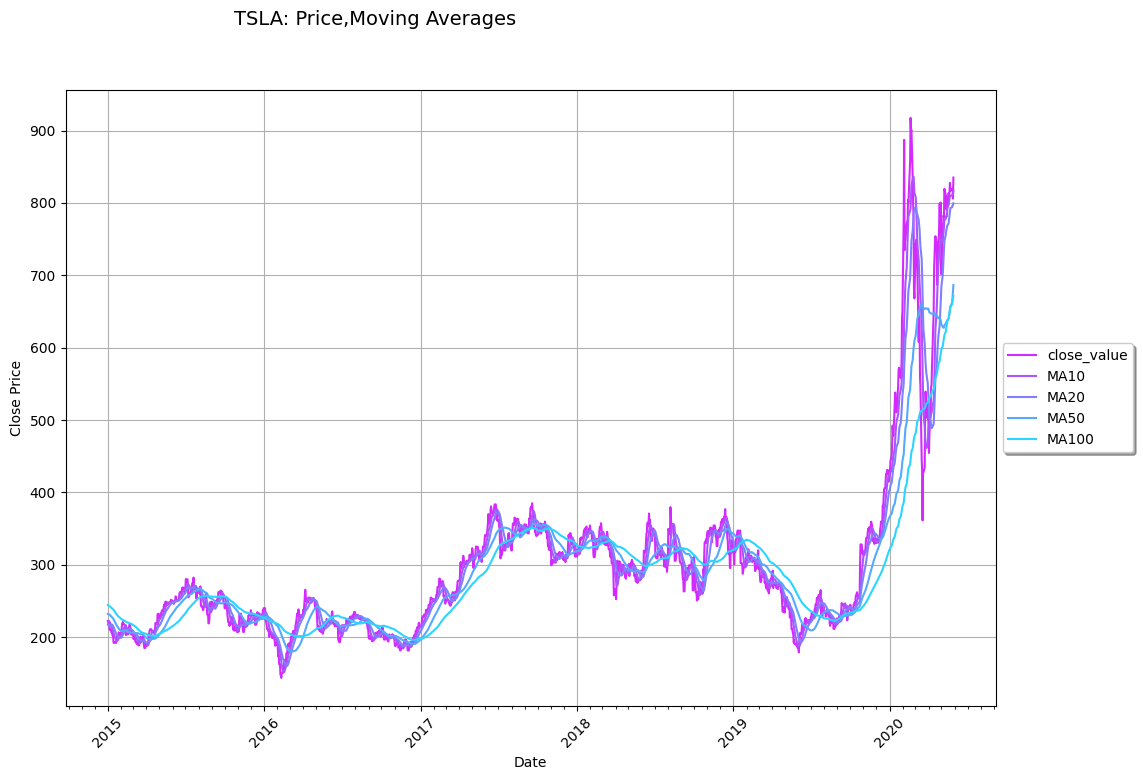

In [6]:
start='2015-01-01'
end='2020-12-31'
ticker='TSLA'
# get data
sp=subset_prices(d,ticker,start,end) #get price info
fig,ax=plt.subplots(figsize=(12, 8))
fig.suptitle(ticker+ ": Price,Moving Averages",fontsize=14,horizontalalignment='right', verticalalignment='top')
price_plot_ma(ax=ax,df=sp)

<Axes: xlabel='Date', ylabel='Sentiment'>

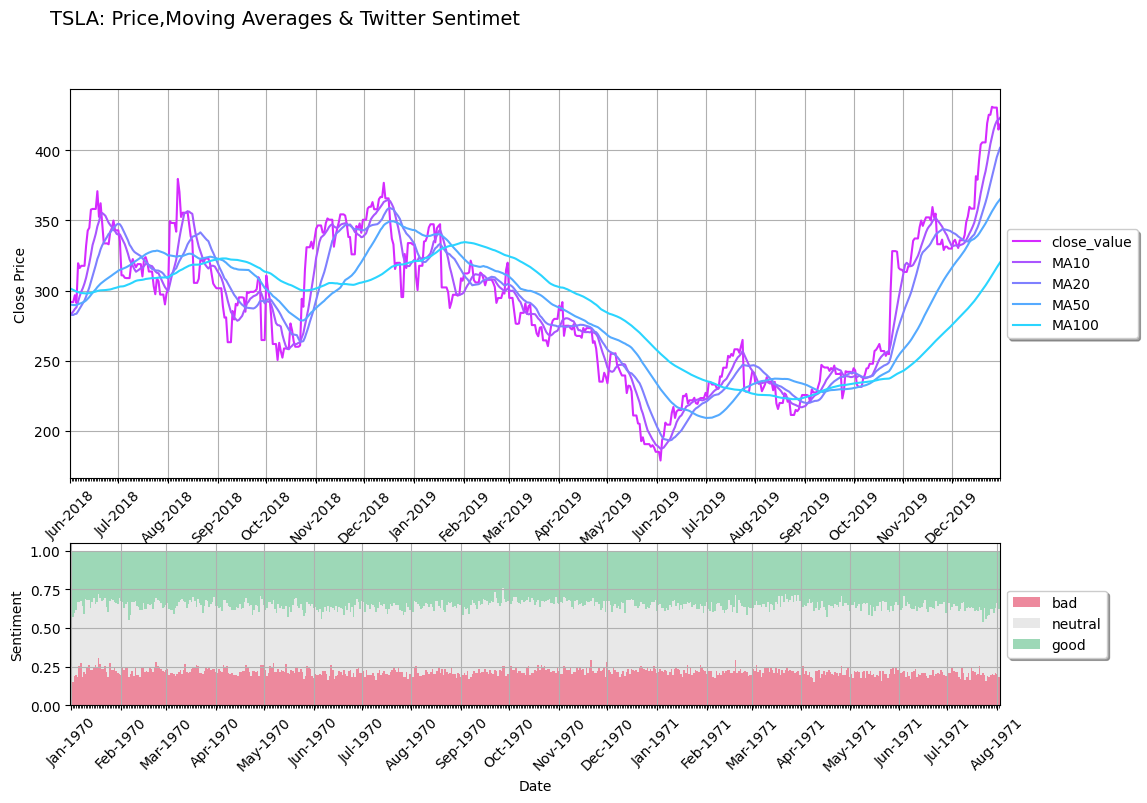

In [7]:
start='2018-06-01'
end='2019-12-31'
ticker='TSLA'
# get data
sp=subset_prices(d,ticker,start,end) #get price info
tw=get_sentiment(tweets,ticker,start,end) # get tweets
gridsize = (3, 2) # 3 rows, 2 cols
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
ax1.set_xlim(min(sp.date),max(sp.date))
ax2 = plt.subplot2grid(gridsize, (2, 0), colspan=2, rowspan=1)
fig.suptitle(ticker+ ": Price,Moving Averages & Twitter Sentimet",fontsize=14,horizontalalignment='right', verticalalignment='top')
fig.subplots_adjust(hspace=0.4)
price_plot_ma(ax=ax1,df=sp)
sentiment_barplot(ax=ax2,df=tw)

<Axes: xlabel='Date', ylabel='Tweet Volume'>

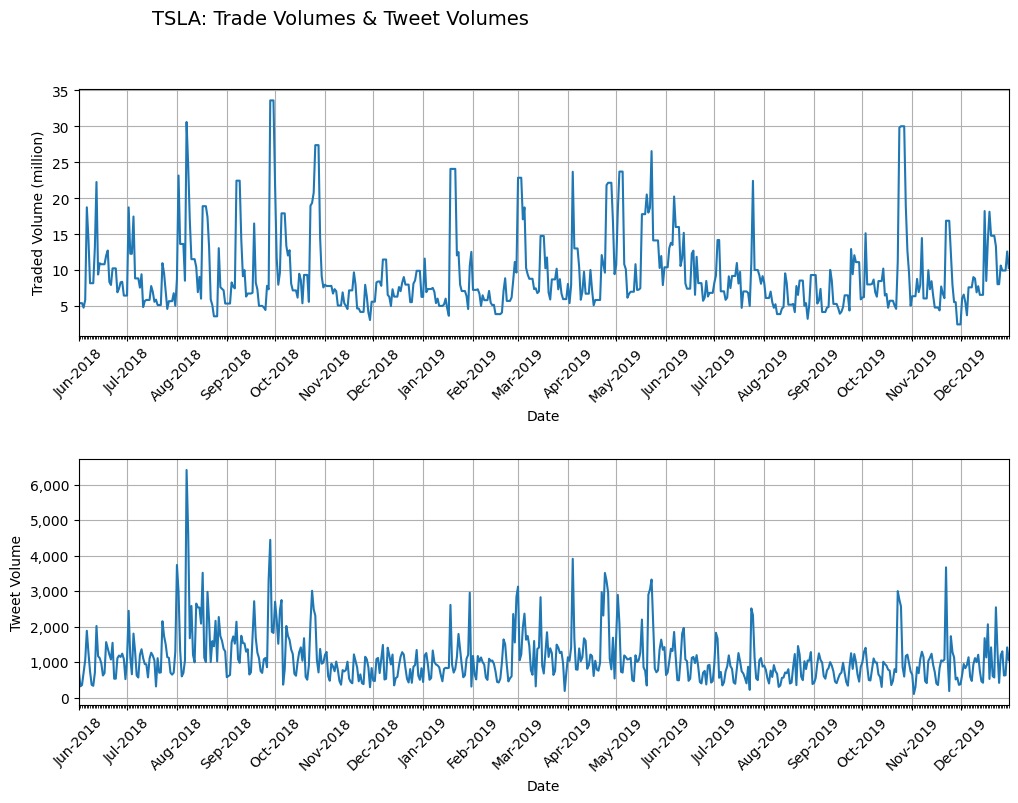

In [8]:
gridsize = (2, 2) # 2 rows, 2 cols
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (1, 0), colspan=2, rowspan=1)
fig.suptitle(ticker+ ": Trade Volumes & Tweet Volumes",fontsize=14,horizontalalignment='right', verticalalignment='top')
fig.subplots_adjust(hspace=0.5)
ax1.set_xlim(min(sp.date),max(sp.date))
ax2.set_xlim(min(tw.date),max(tw.date))
price_plot_vol(ax=ax1, df=sp)
sentiment_tweet_vol(ax=ax2,df=tw)

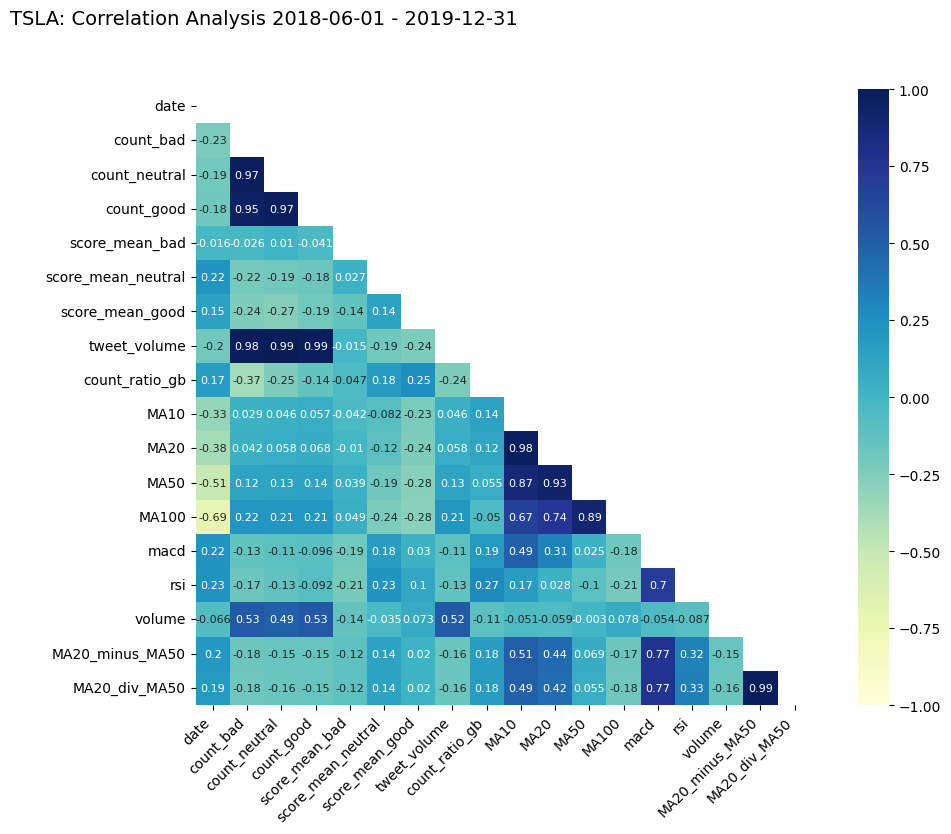

In [9]:
fig,ax = plt.subplots(figsize=(12, 8))
fig.suptitle(ticker + ": Correlation Analysis "+ start+ " - " + end,fontsize=14,horizontalalignment='right', verticalalignment='top')
ax=corr_plot(sp,tw)

In [10]:
for i in tw.sort_values('score',ascending=False).body.head(10):
    print(i, sep="\n")
    print(" ")

Today's Highlight from Pre-Market Notes 5/17/2019$OTLK LONG $1.19-->$2.77 #SWING$AMAT LONG $42-->$44$NVDA LONG $158-->$163$BA LONG $352-->$360$BYND LONG $90-->$96$PINS LONG $26-->$28$BOOT LONG $27-->$30$TSLA LONG $217-->$220$BIDU LONG $130-->$134
 
Today's Highlight from Pre-Market Notes 5/21/2019$MNK LONG $8.50-->10$BA SHORT $362-->355$ARRY LONG $20-->25$TSLA LONG $197-->203$QRVO LONG $62-->68$LITE LONG $46-->49$TTD LONG $190-->198$LITE LONG $200-->207$NVDA LONG $152.75-->156$ARWR LONG $21
 
I've been rolling options premiums for years on $TSLA. You guys have kept the theta so high in what should be a sleepy boring stock. But yeah, I would call that long term since its IPO. Buy and hold is not the only way to play long term growth.
 
hehe Beavis: $TSLA is waiting for boring and boneheaded questions of those analysts tonight; hehe; but watch our for real cool stuff happening than. Gonna be so great, greatest Q2 call ever, amazing linguistic talents will unfold, new words created like f

In [11]:
for i in tw.sort_values('score',ascending=False).body.tail(10):
    print(i)
    print(" ")
    

Is there something just filthy, rotten, stinking, nasty, corrupt, vile, disgusting, polluted, & tainted about Chicago politics? Well, sure, but it is any more filthy, rotten, stinking, nasty, corrupt, vile, disgusting, polluted, or tainted than $TSLA corporate governance? Nope.
 
Corey STFU. You’re a f..king short, no consideration for anything but your dirty pockets! I hope one day you will get the hell you deserve! You are a selfish shit moron, your actions are a disgrace to the people that will suffer from #ClimateWarming and as such it’s criminal!
 
#Long$TSLA 345.73Rocketing through secondary resistance 321-324. Challenged upper-head resistance 341-346. Short squeeze in progress. Rocketing through primary resistance 289-292 in death cross pattern. Short squeeze in progress. Nr Term Obj 406, Stop Loss 298. Volatile.
 
A spike in an otherwise continuing downward trans production hell, financial hell, customer service hell and lastly valuation hell $tsla oh and Sell sell sell $tsla
 

<Axes: xlabel='Date', ylabel='Close Price'>

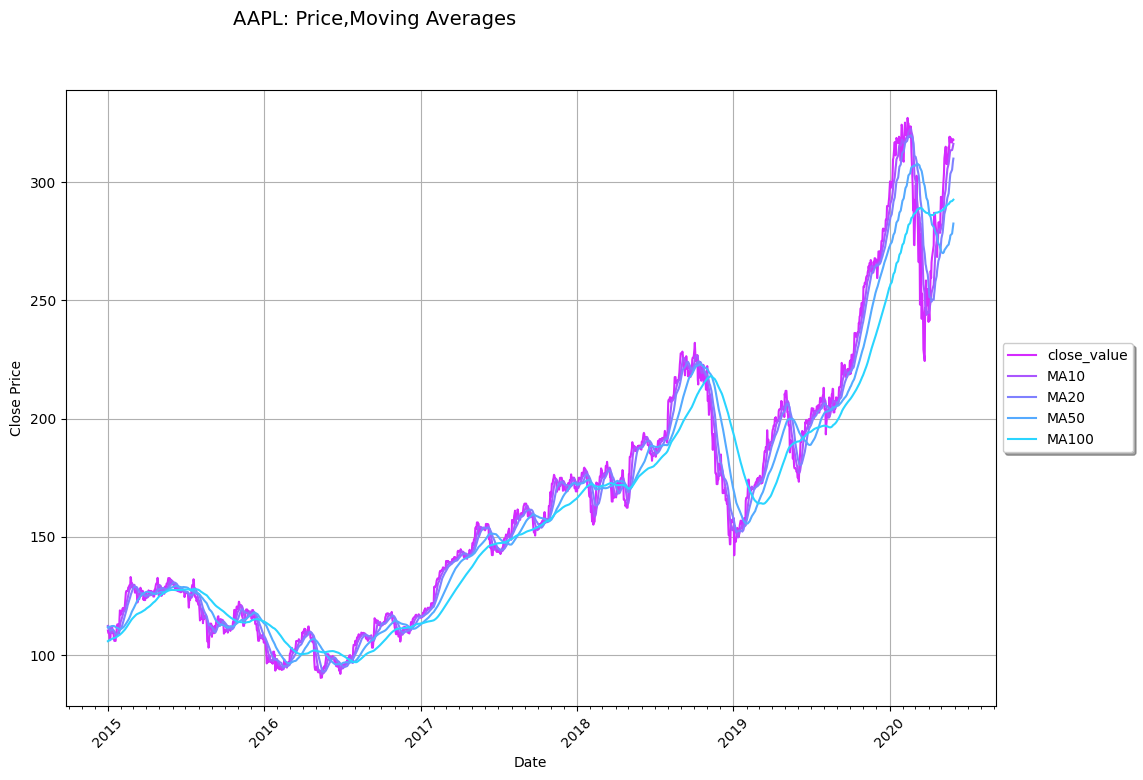

In [12]:
start='2015-01-01'
end='2020-12-31'
ticker='AAPL'
# get data
sp=subset_prices(d,ticker,start,end) #get price info
fig,ax=plt.subplots(figsize=(12, 8))
fig.suptitle(ticker+ ": Price,Moving Averages",fontsize=14,horizontalalignment='right', verticalalignment='top')
price_plot_ma(ax=ax,df=sp)

<Axes: xlabel='Date', ylabel='Tweet Volume'>

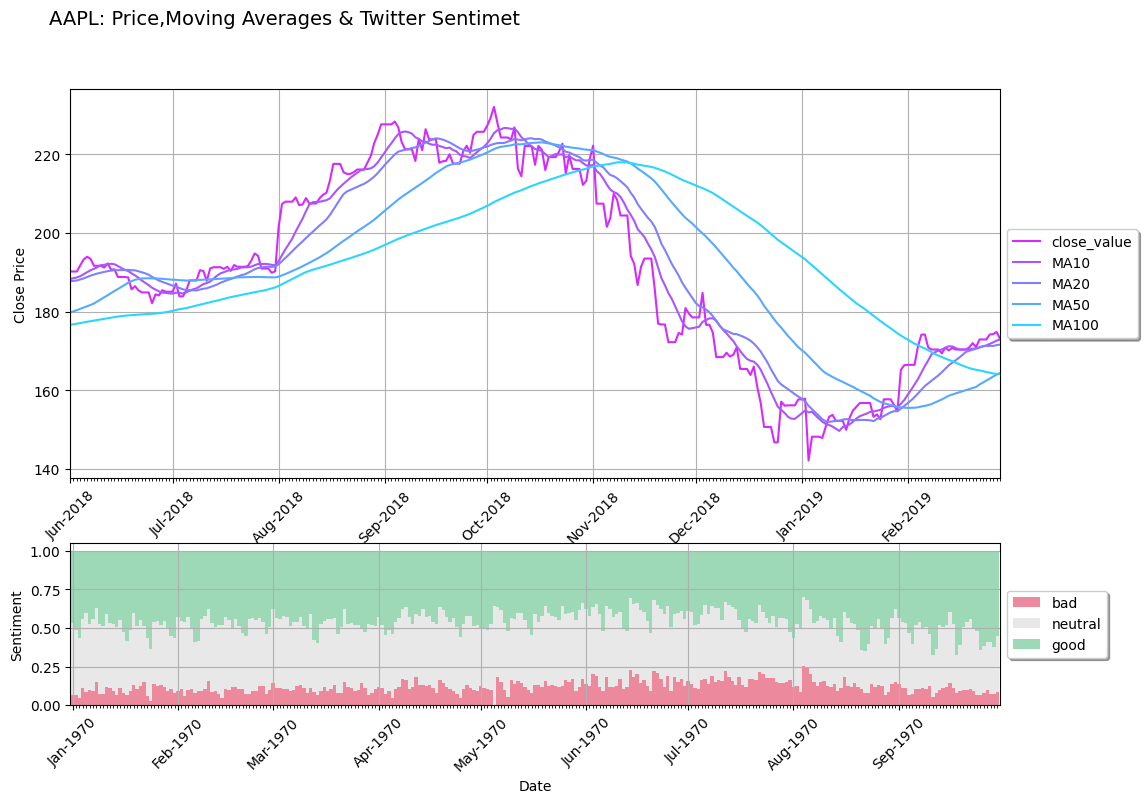

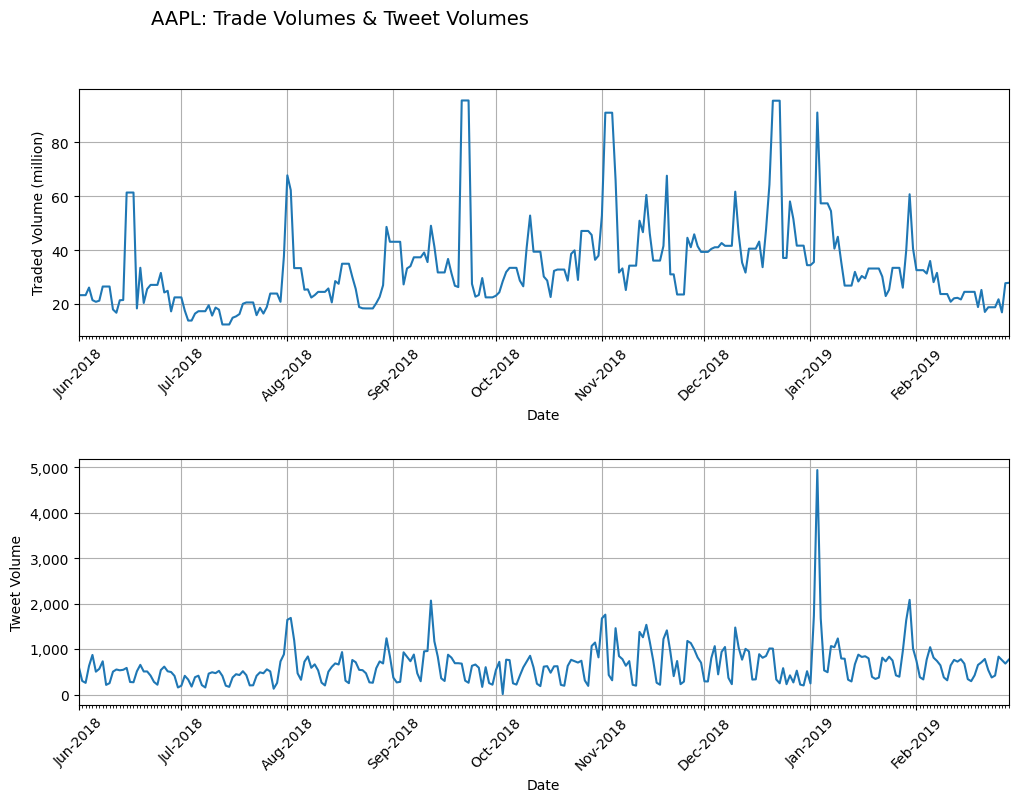

In [13]:
start='2018-06-01'
end='2019-02-28'
ticker='AAPL'
# get data
sp=subset_prices(d,ticker,start,end) #get price info
tw=get_sentiment(tweets,ticker,start,end) # get tweets
gridsize = (3, 2) # 3 rows, 2 cols
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
ax1.set_xlim(min(sp.date),max(sp.date))
ax2 = plt.subplot2grid(gridsize, (2, 0), colspan=2, rowspan=1)
fig.suptitle(ticker+ ": Price,Moving Averages & Twitter Sentimet",fontsize=14,horizontalalignment='right', verticalalignment='top')
fig.subplots_adjust(hspace=0.4)
price_plot_ma(ax=ax1,df=sp)
sentiment_barplot(ax=ax2,df=tw)

gridsize = (2, 2) # 2 rows, 2 cols
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (1, 0), colspan=2, rowspan=1)
fig.suptitle(ticker+ ": Trade Volumes & Tweet Volumes",fontsize=14,horizontalalignment='right', verticalalignment='top')
fig.subplots_adjust(hspace=0.5)
ax1.set_xlim(min(sp.date),max(sp.date))
ax2.set_xlim(min(tw.date),max(tw.date))
price_plot_vol(ax=ax1, df=sp)
sentiment_tweet_vol(ax=ax2,df=tw)

In [14]:
for i in tw.sort_values('score',ascending=False).body.head(10):
    print(i, sep="\n")

$FAANG - $FB $AMZN $AAPL $NFLX $GOOGL - A daily 3 month chart. #Facebook in main #bull trend + #short move, #Amazon in bull trend with long tail down #Apple in main bull trend #Netflix bull in long tail down #Alphabet bull trend with triple bottom breakout
07-27: the top scored Health Care company is CELLDEX THERAPEUTICS IN$CLDX scored at 63.22Key words: GROWTH, EXPECTING, PRICE, DREAM, GOOD, STRONG, BUYING, DOWN, MARKET, BUY, SELLING, TRADING, SUCCESS, DELISTING, BETTER, BEST, SERIOUS..#startup $BTC $AMD $AAPL $NFLX #crypto
buy $FB buy $AAPL buy buy buy as the FAANG man says. So people buy buy buy.  Can only imagine what pct these make up in this market
Depends on your time horizon, of course, but you don’t need a very long time horizon 2 benefit from buying $AAPL. This is such a great company w/so many great products, a vast & loyal customer base, & tremendous potential 4 news products, services & growth — U have 2B a buyer.
Yes I know. You made all that money by that $2 stock price 

In [15]:
for i in tw.sort_values('score',ascending=False).body.tail(10):
    print(i, sep="\n")

$CGC tried long cuz of wicks and VWAP bounce. horrible entry$MDT short on open. Huge gap up with no pullback on daily so many will be taking profits. short rejection of VWAP but there was weird buying volumemissed alot of trades: $AAPL short $TOL short $CRON short $CGC short
loser day $AMD failed to hold above VWAP so short under it$AAPL short VWAP reject$FB got the opening short. tried long as it held higher low in hindsight could have went long after VWAP reclaim, but i called it a day missed plays: $BABA short $AMZN short
@shorty4444 @NoobTrader1337 No, but may initiate a short soon. My short portfolio is $AMD $ZS $COUP $OKTA. Closed $AAPL short. Killer day.
Call me crazy but I think $AAPL makes low tomorrow morning and rallies. The 40% sell off since October was for this bad Q - nothing new. Buy the rumor sell the news. Already baked in.
Call me crazy but I think $AAPL makes low tomorrow morning and rallies. The 40% sell off since October was for this bad Q - nothing new. Buy the r

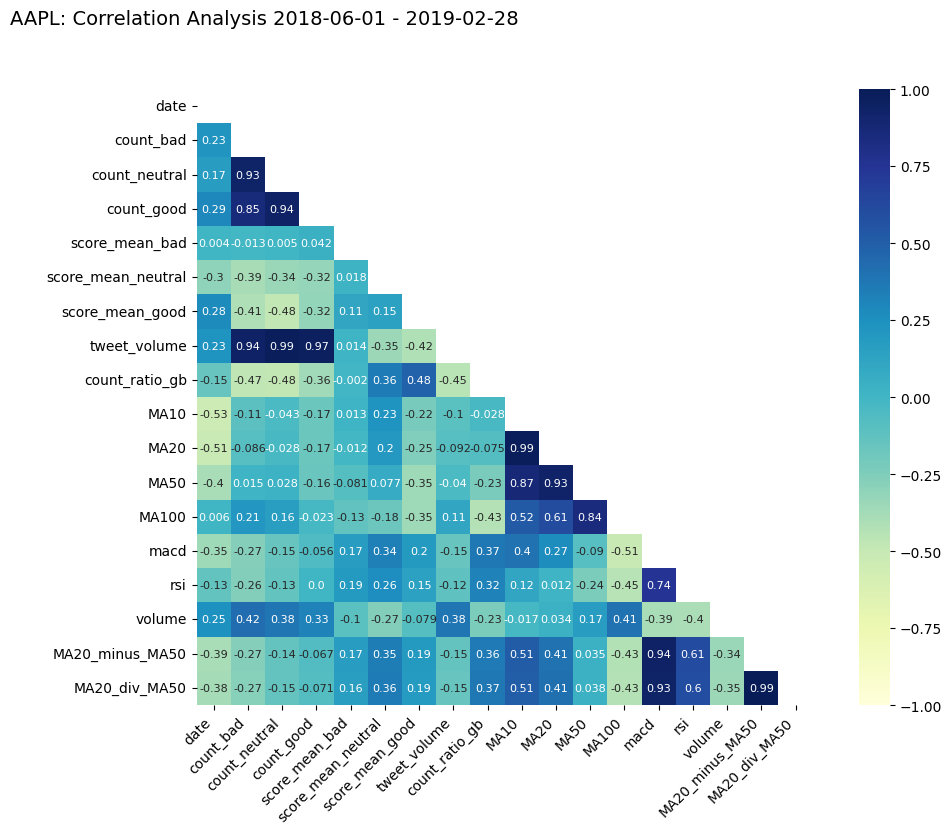

In [16]:
fig,ax = plt.subplots(figsize=(12, 8))
fig.suptitle(ticker + ": Correlation Analysis "+ start+ " - " + end,fontsize=14,horizontalalignment='right', verticalalignment='top')
ax=corr_plot(sp,tw)

<Axes: xlabel='Date', ylabel='Close Price'>

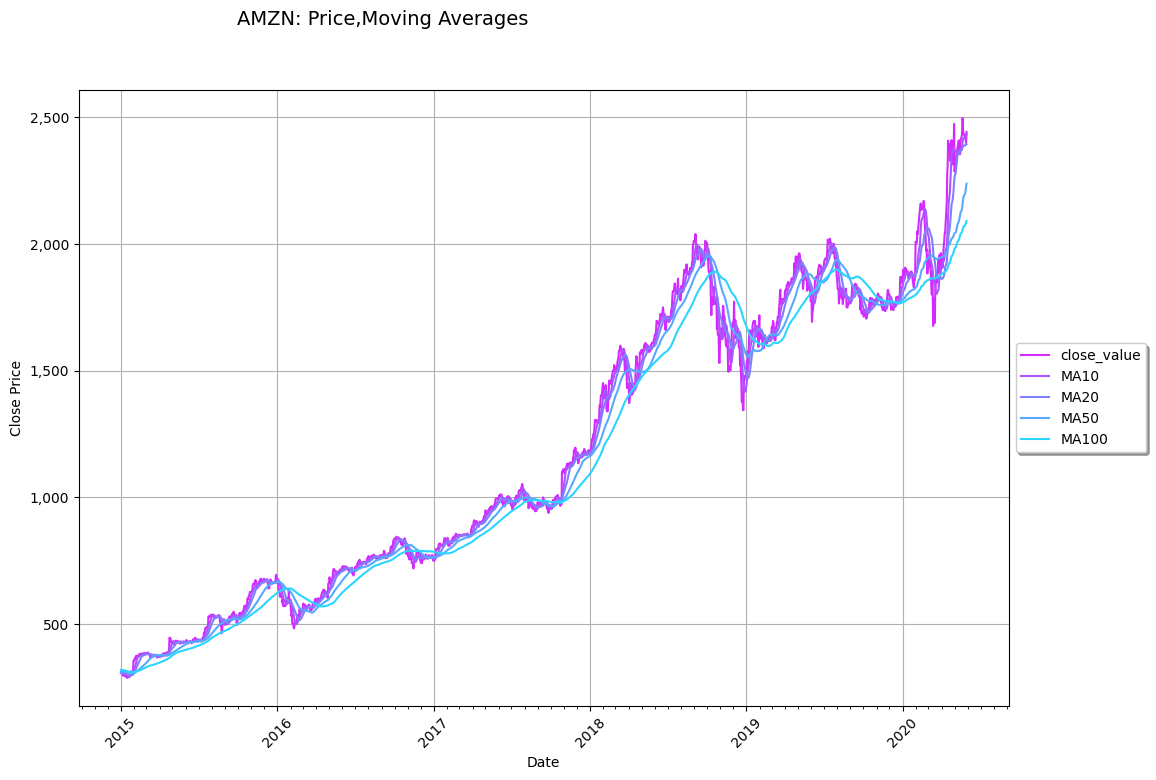

In [17]:
start='2015-01-01'
end='2020-12-31'
ticker='AMZN'
# get data
sp=subset_prices(d,ticker,start,end) #get price info
fig,ax=plt.subplots(figsize=(12, 8))
fig.suptitle(ticker+ ": Price,Moving Averages",fontsize=14,horizontalalignment='right', verticalalignment='top')
price_plot_ma(ax=ax,df=sp)

<Axes: xlabel='Date', ylabel='Tweet Volume'>

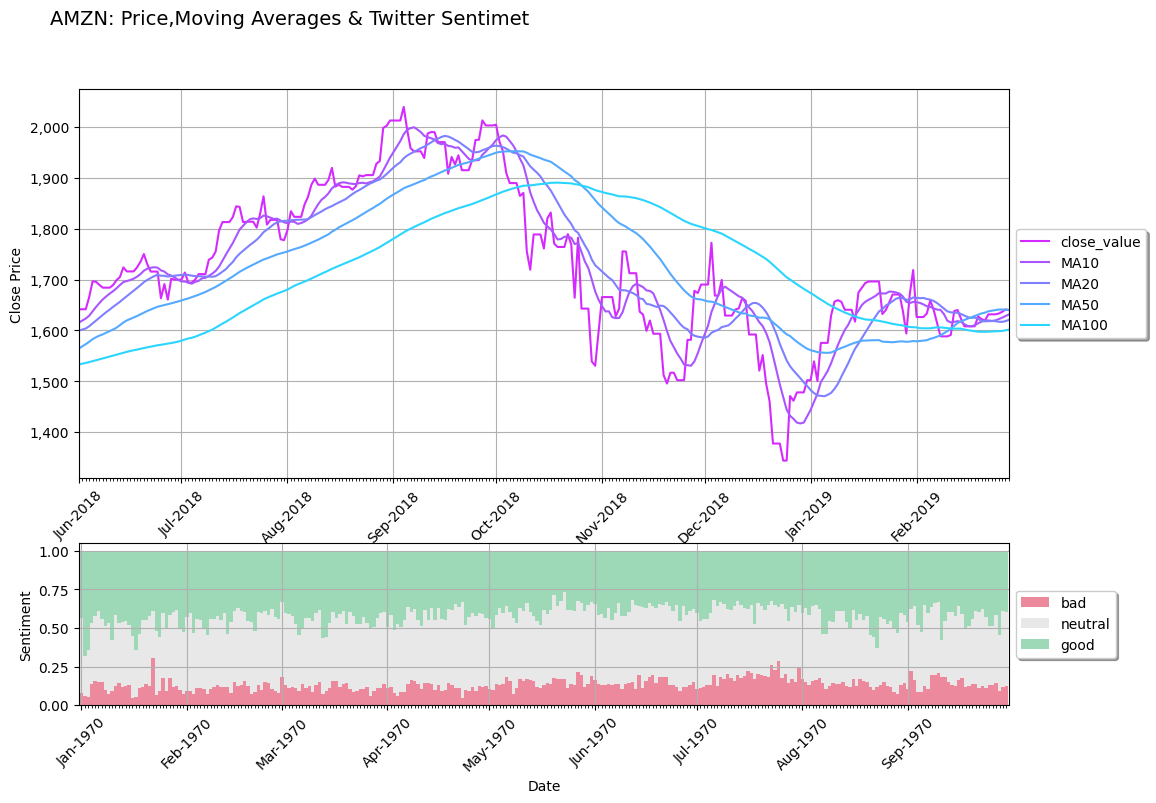

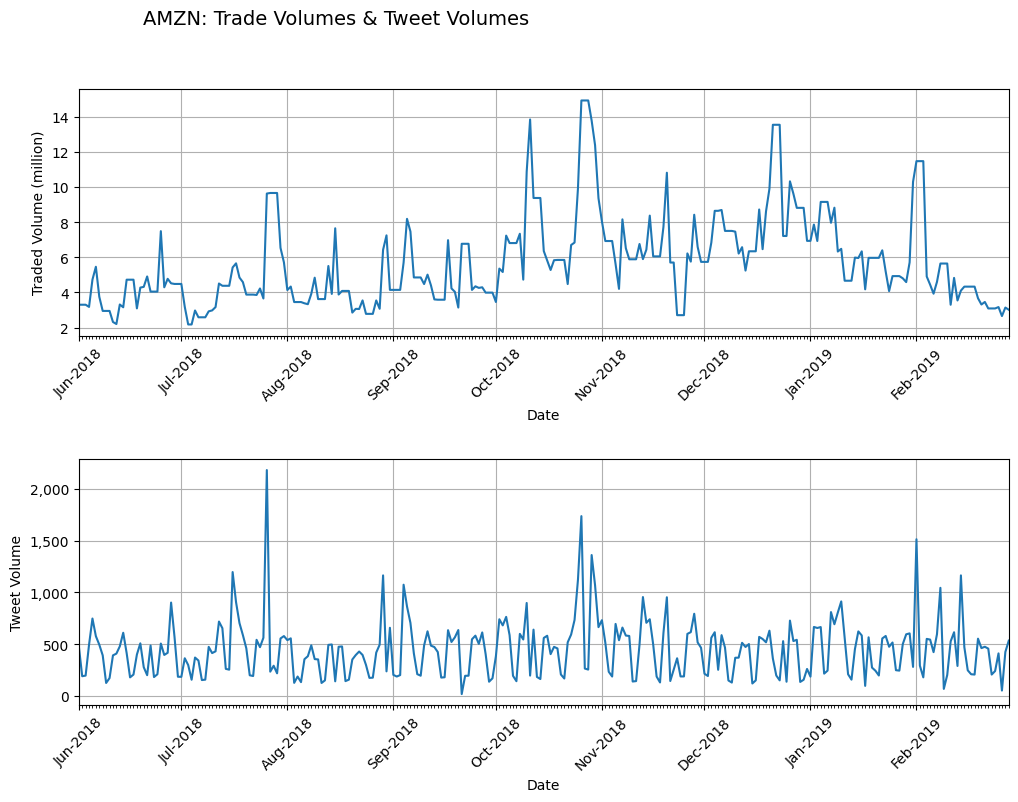

In [18]:
start='2018-06-01'
end='2019-02-28'
# get data
sp=subset_prices(d,ticker,start,end) #get price info
tw=get_sentiment(tweets,ticker,start,end) # get tweets
gridsize = (3, 2) # 3 rows, 2 cols
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
ax1.set_xlim(min(sp.date),max(sp.date))
ax2 = plt.subplot2grid(gridsize, (2, 0), colspan=2, rowspan=1)
fig.suptitle(ticker+ ": Price,Moving Averages & Twitter Sentimet",fontsize=14,horizontalalignment='right', verticalalignment='top')
fig.subplots_adjust(hspace=0.4)
price_plot_ma(ax=ax1,df=sp)
sentiment_barplot(ax=ax2,df=tw)

gridsize = (2, 2) # 2 rows, 2 cols
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (1, 0), colspan=2, rowspan=1)
fig.suptitle(ticker+ ": Trade Volumes & Tweet Volumes",fontsize=14,horizontalalignment='right', verticalalignment='top')
fig.subplots_adjust(hspace=0.5)
ax1.set_xlim(min(sp.date),max(sp.date))
ax2.set_xlim(min(tw.date),max(tw.date))
price_plot_vol(ax=ax1, df=sp)
sentiment_tweet_vol(ax=ax2,df=tw)

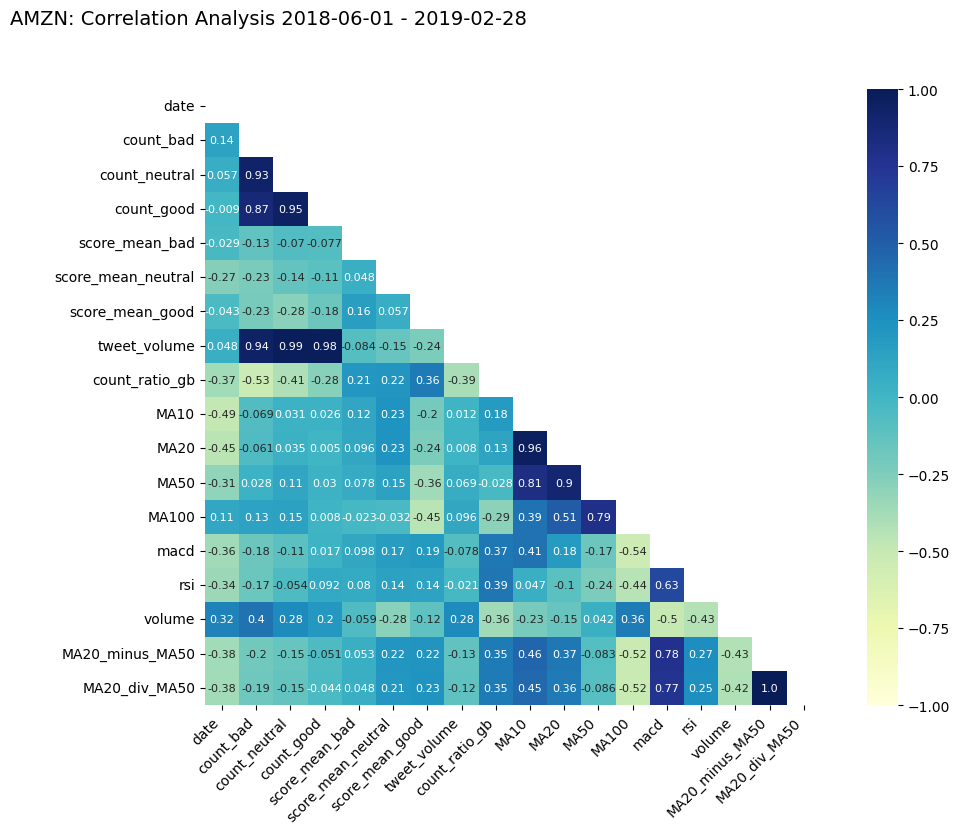

In [19]:
fig,ax = plt.subplots(figsize=(12, 8))
fig.suptitle(ticker + ": Correlation Analysis "+ start+ " - " + end,fontsize=14,horizontalalignment='right', verticalalignment='top')
ax=corr_plot(sp,tw)